In [1]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pandas.api.types import CategoricalDtype
import scipy as sp
from pathlib import Path
import tkinter as tk
from tkinter import filedialog
import itertools
from colour import Color
from datetime import date
import statsmodels.api as sm
from statsmodels.stats.weightstats import ztest as ztest
from sklearn.metrics import r2_score as R2S
import cairo

#from lmfit import Model

In [2]:
today = date.today()
print("Today's date:", today)
date = str(today)
date

Today's date: 2024-05-06


'2024-05-06'

In [3]:
tubulin = '[Tubulin] (' r'$\mu$' 'M)'
tub = 'tub'

DCXconc = '[DCX] (nM)' 
EBconc = '[EB] (nM)'
DCX = 'DCX'
Type = 'DCX Type'

Concentration = 'Concentration (' r'$\mu$' 'M)'
Length = 'Length (' r'$\mu$' 'm)'
Lifetime = 'Lifetime (min)'
GrowthRate = 'Growth Rate (' r'$\mu$' 'm/min)'
TimeToNucleate = 'Time to Nucleate (min)'
ShrinkageLength = 'Shrink Length (' r'$\mu$' 'm)'
ShrinkageLifetime = 'Shrink Lifetime (min)'
ShrinkageRate = 'Shrink Rate (' r'$\mu$' 'm/min)'
RescuePerLength = 'Rescues (' r'$\mu$' 'm' r'$^{-1}$' ')'

In [4]:
Type_order = ['None', 'Y64N','R76S','R102S', 'R178L', 'P191R', 'G223E','R303X', 'WT']

category_Type = CategoricalDtype(Type_order, ordered=True,) #order mutants

In [51]:
black = '#000000'
grey = '#777777'
blue = '#23459C'
cyan = '#0089CF'
green = '#79BA1A'
purple = '#AB4A9C'
lily = '#CB81EA'
magenta = '#D80B8C'
red = '#e60000'
orange = '#FF7300'
darkorange = '#FF5B00'
lightorange = '#FFAC83'
yellow = '#FFCB05'
lightyellow = '#F9DC2D'
pink = '#FFA4CD'
StartHue1 = Color(purple)
DC1color = list(StartHue1.range_to(Color(pink),3))
StartHue2 = Color(darkorange)
DC2color = list(StartHue2.range_to(Color(lightorange),3))
print(DC1color,DC2color)

DC1palette = list(map(Color.get_hex,DC1color))

palette_all = [grey] + [DC1palette[0]] + [DC1palette[1]] + list(map(Color.get_hex,DC2color)) + [cyan]

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]

[<Color #ab4a9c>, <Color #e468b8>, <Color #ffa4cd>] [<Color #ff5b00>, <Color #ff8341>, <Color #ffac83>]


In [6]:
### font for matplotlib
matplotlib.rcParams['font.family'] = 'Helvetica Neue LT Std'

#  Open saved fit parameters  #

In [7]:
askFitParam = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the selected file
ResultFit = pd.read_csv(askFitParam, encoding='utf-8')
ResultFit[Type] = ResultFit[Type].fillna('None')
ResultFit

,Fit,SE,Coefficient,[Tubulin] ($\mu$M),DCX Type,[DCX] (nM),Parameter,Moment
0,1.070577,0.008903,0.0,12,None,0,Growth Rate ($\mu$m/min),Mean
1,0.157043,0.007290,1.0,12,None,0,Growth Rate ($\mu$m/min),Std
2,0.797346,0.025314,0.0,8,None,0,Growth Rate ($\mu$m/min),Mean
3,0.149149,0.020669,1.0,8,None,0,Growth Rate ($\mu$m/min),Std
4,0.416686,0.002427,0.0,6,None,0,Growth Rate ($\mu$m/min),Mean
...,...,...,...,...,...,...,...,...
363,5.080860,0.468668,1.0,14,None,0,Shrink Rate ($\mu$m/min),Std
364,19.051355,0.549069,0.0,10,None,0,Shrink Rate ($\mu$m/min),Mean
365,5.591572,0.456008,1.0,10,None,0,Shrink Rate ($\mu$m/min),Std
366,12.426828,0.919834,0.0,7,None,0,Shrink Rate ($\mu$m/min),Mean


In [8]:
ResultFit = ResultFit[(ResultFit['DCX Type'] != 'R303X') & (ResultFit['DCX Type'] != 'R102S')]
ResultFit['DCX Type'].unique()

array(['None', 'Y64N', 'R76S', 'R178L', 'P191R', 'G223E', 'WT'],
      dtype=object)

In [9]:
resultdirectory = str(Path(askFitParam).parent)+'//Plots_'+date
newmydir = Path(resultdirectory)
newmydir.mkdir(exist_ok=True)
newmydir

WindowsPath('C:/Users/sofia/OneDrive - McGill University/EJCB2023/Sofia_EJCB_Figs/Data/2023-08-08_fitdata-final/Plots_2024-05-06')

## dcx EQ FIT ##

In [13]:
def pickdata(dcxtype, parameterNo):
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Moment']=='Mean')& (ResultFit[tubulin]==6)]

    parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[parameterNo]]

    x = parameterMeanDF[DCXconc].values
    y = parameterMeanDF['Fit'].values
    yerr = parameterMeanDF['SE'].values
    
    return x,y,yerr

In [14]:
def hillEQ(x, n, kd, Y):
    return  (YL[-1]- Y[0]) * np.power(x, n)/(kd + np.power(x, n)) + Y[0]

In [15]:
def reduced_chi_squared(obs,fit,sigma,freedom): 

    return np.sum(np.square(fit - obs)/np.square(sigma)) / freedom

In [16]:
x,y,yerr = pickdata('WT', 2)
x0,y0,yerr0 = pickdata('None', 2)

X = [*x0,*x]
YL = [*y0,*y]
YerrL = [*yerr0,*yerr]

logx = np.log(X[1:-1])
normyL =( YL[1:-1]-YL[0])/(YL[-1]-YL[0])
logyL = np.log(normyL/(1-normyL))

p, cov = np.polyfit(logx, logyL, 1, cov=True)
var = np.diagonal(cov) #Refer [3]
SElin = np.sqrt(var) #Refer [4]

mL,bL = p


p, SElin

(array([  3.24769793, -13.0913579 ]), array([0.5427463 , 2.26854382]))

In [17]:
linfitYL = np.multiply(logx,mL) + bL

In [18]:
R2S(logyL,logx*mL+bL)

0.947098541668598

In [19]:

fitYL = hillEQ(X,p[0], np.exp(-p[1]),YL)
fitYL

array([ 3.84602165,  5.07852635,  8.41376882, 10.56691598, 11.98210304,
       12.70987654])

In [20]:
v = len(YL) - 2

In [21]:
reduced_chi_squared(YL,fitYL,YerrL,v)

0.046920562085981415

In [22]:
def hill_plot_fitMUT(dcxtype):
    x,y,yerr = pickdata(dcxtype, 2)
    x0,y0,yerr0 = pickdata('None', 2)

    X = np.array(x)
    YLmut = np.array(y)
    YerrLmut = yerr

    logxmut = np.log(X[1:])
    normyL =( YLmut[1:]-YLmut[0])/(YL[-1]-YLmut[0])
    logyLmut = np.log(normyL/(1-normyL))

    pmut, cov = np.polyfit(logxmut, logyLmut, 1, cov=True)
    var = np.diagonal(cov) #Refer [3]
    SElinmut = np.sqrt(var) #Refer [4]

    return    pmut, SElinmut


In [23]:
x,y,yerr = pickdata('R76S', 2)
x0,y0,yerr0 = pickdata('None', 2)

X = np.array(x)
YL76 = np.array(y)
YerrL76 = yerr

p76 , SE76 = hill_plot_fitMUT('R76S')
p76 , SE76

(array([  3.22323167, -17.71173874]), array([1.08894694, 5.08725883]))

In [24]:
fitYL76 = hillEQ(X,p76[0], np.exp(-p76[1]),YL76)
fitYL76

array([3.46563959, 3.5381493 , 3.69424532, 4.19801844, 7.60299689])

In [25]:
reduced_chi_squared(YL76,fitYL76,YerrL76,v)

1.2224861527628819

In [26]:
#K_A76
np.exp(-p76[1]/p76[0])

243.47762499225396

In [27]:
x,y,yerr = pickdata('P191R', 2)
x0,y0,yerr0 = pickdata('None', 2)

X = np.array(x)
YL191 = np.array(y)
YerrL191 = yerr

p191 , SE191 = hill_plot_fitMUT('P191R')
p191 , SE191

(array([  2.50104811, -14.14968789]), array([0.3204507 , 1.49705701]))

In [28]:
fitYL191 = hillEQ(X,p191[0], np.exp(-p191[1]),YL191)
fitYL191

array([2.98682482, 3.11682823, 3.32422615, 3.84095945, 6.48124947])

In [29]:
reduced_chi_squared(YL191,fitYL191,YerrL191,v)

0.055480114895983666

In [30]:
def K_A(p):
    return np.exp(-p[1]/p[0]) , np.exp(-p[1]/p[0])/p[0]*np.sqrt(np.square(SElin[1])+np.square(p[1]*SElin[0]/p[0]))

In [31]:
K_A(p)

(56.31525016671599, 54.6492929359395)

In [32]:
K_A(p76)

(243.47762499225396, 283.0524919953073)

In [33]:
K_A(p191)

(286.4326089565408, 437.2218206763234)

NameError: name 'logx76' is not defined

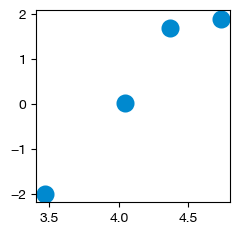

In [34]:
scattersize = 9
cap = 5

fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.errorbar(logx , logyL , yerr= 0 , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=cyan, alpha = 1, ls='')
ax.errorbar(logx76 , logyL76 , yerr= 0 , fmt='',marker='^', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=pink, alpha = 0.5, ls='')
ax.errorbar(logx191 , logyL191 , yerr= 0 , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=orange, alpha = 0.75, ls='')


x0 = np.arange(3.3, 6, 0.05)

ax.plot(x0, x0*mL+bL,color = cyan, lw=3,ls= '-',alpha = 0.5)
ax.plot(x0, x0*mL76+bL76,color = pink, lw=3,ls= '-',alpha = 0.5)
ax.plot(x0, x0*mL191+bL191,color = orange, lw=3,ls= '-',alpha = 0.5)
# ax.set_ylim(-2.5,2.5)
# ax.set_xlim(3,5)
ax.set_xlabel(r'$\log([$''DCX' r'$])$')
#ax.set_xticks(np.arange(0, 22.1, 2))
#ax.set_yticks(np.arange(0, 150.1, 25))
ax.set_ylabel(r'$\log(\frac{L_N}{1-L_N})$') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)

#ax.legend((r'$n=2.94 \pm 0.49$' '\n' r'$R^2 > 0.945$',),loc='lower right',title='Hill Equation')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

#plt.savefig(newmydir/('logexpHillfit_Lifetime_'+date+'.pdf'), bbox_inches = 'tight')

In [ ]:
def pickdata(dcxtype, parameterNo):
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Moment']=='Mean')& (ResultFit[tubulin]==6)]

    parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[parameterNo]]

    x = parameterMeanDF[DCXconc].values
    y = parameterMeanDF['Fit'].values
    yerr = parameterMeanDF['SE'].values
    
    return x,y,yerr

In [35]:
ResultFit[Type].unique()[1:-1]

array(['Y64N', 'R76S', 'R178L', 'P191R', 'G223E'], dtype=object)

In [36]:
def reduced_chi_squared(obs,fit,sigma,freedom): 

    return np.sum(np.square(fit - obs)/np.square(sigma)) / freedom

In [37]:
def lin_fit(dcxtype,paramNo,coeff):
    x,y,yerr = pickdata(dcxtype,paramNo)
    x0,y0,yerr0 = pickdata('None',paramNo)
    
    X = [*x0,*x]
    Y = [*y0,*y]
    Yerr = [*yerr0,*yerr]
    
    p, cov = np.polyfit(X,Y, 1, cov=True)
    var = np.diagonal(cov) #Refer [3]
    SElin = np.sqrt(var) #Refer [4]

    fitY = np.multiply(X,p[0])+p[1]
    
    R = R2S(Y,fitY)

    chi = reduced_chi_squared(Y,fitY,Yerr,len(Y)-2)
    
    return p, SElin, R, chi

In [89]:

lin_fit_results = pd.DataFrame(columns=[] , index=[])

for dcxtype in ResultFit[Type].unique()[1:-1]:#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    p , SElin, R, chi = lin_fit(dcxtype,2)

    results0 = {'DCX Type': [dcxtype], 'Slope': [p[0]], 'Slope SD': [SElin[0]], 'Intercept': [p[1]], 'Intercept SD': [SElin[1]], 'R^2': [R], 'chi^2': [chi]}

    lin_fit_results = pd.concat([lin_fit_results, pd.DataFrame(results0)], sort=False)



In [90]:
x,y,yerr = pickdata('WT', 2)
x0,y0,yerr0 = pickdata('None', 2)

X = [*x0,*x][:-2]
Y = [*y0,*y][:-2]
Yerr = [*yerr0,*yerr][:-2]

p, cov = np.polyfit(X,Y, 1, cov=True)
var = np.diagonal(cov) #Refer [3]
SElin = np.sqrt(var) #Refer [4]

fitY = np.multiply(X,p[0])+p[1]

R = R2S(Y,fitY)

chi = reduced_chi_squared(Y,fitY,Yerr,len(Y)-2)




results0 = {'DCX Type': ['WT'], 'Slope': [p[0]], 'Slope SD': [SElin[0]], 'Intercept': [p[1]], 'Intercept SD': [SElin[1]], 'R^2': [R], 'chi^2': [chi]}
lin_fit_results = pd.concat([lin_fit_results, pd.DataFrame(results0)], sort=False)

lin_fit_results['Relative Slope'] = lin_fit_results['Slope']/p[0]
lin_fit_results['Relative Slope SE'] = lin_fit_results['Slope']/p[0] * np.sqrt(np.square(SElin[0]/p[0])+np.square(lin_fit_results['Slope SD']/lin_fit_results['Slope']))

lin_fit_results

,DCX Type,Slope,Slope SD,Intercept,Intercept SD,R^2,chi^2,Relative Slope,Relative Slope SE
0,Y64N,0.018012,0.002228,3.600759,0.249191,0.942316,0.356564,0.185343,0.043832
0,R76S,0.013165,0.002512,3.221384,0.280964,0.872855,0.989819,0.135472,0.037602
0,R178L,0.006940,0.002711,4.106672,0.303143,0.621059,0.785782,0.071417,0.031388
0,P191R,0.013090,0.003930,2.802088,0.439475,0.735017,1.493460,0.134694,0.048705
0,G223E,0.016325,0.003312,3.456260,0.370437,0.858596,0.625609,0.167978,0.048042
0,WT,0.097182,0.019588,3.048216,1.004230,0.924857,1.892946,1.000000,0.285041


ValueError: operands could not be broadcast together with shapes (230,) (0,) 

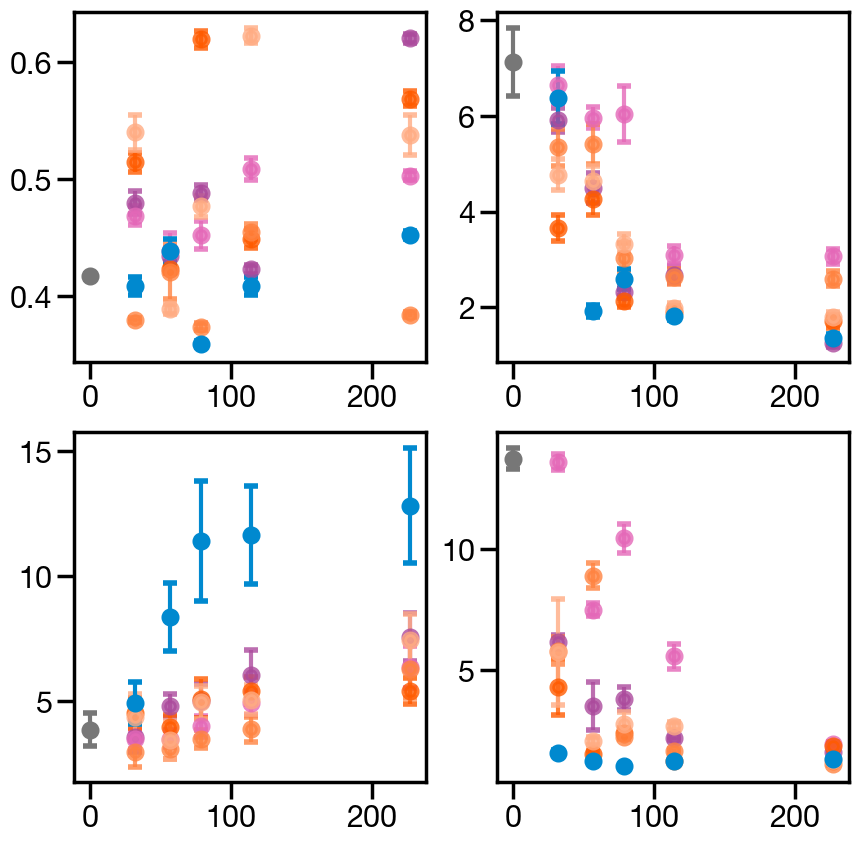

In [82]:
scattersize = 9
cap = 5

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shrinkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

fig, ax = plt.subplots(2,2,figsize=(10,10))

linx = np.arange(0, 230, 1)

# ax[0][0].plot(linx, linx*mG+bG ,color = cyan, lw=3,ls= '-',alpha = 0.5,label='_nolegend_')



linetype = ['','--', ':','--', ':', '-.','-']

count = 0

palette = palette_all
#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
#palette = [grey,cyan]

for dcxtype in ResultFit[Type].unique():#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Moment']=='Mean')& (ResultFit[tubulin]==6)]

    
    
    c=0
    for i in np.arange(len(ax)):
        for j in np.arange(len(ax)):
    
            parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[c]]

            x = parameterMeanDF[DCXconc].values
            y = parameterMeanDF['Fit'].values
            yerr = parameterMeanDF['SE'].values
            
            if dcxtype == 'None' or  dcxtype == 'WT':

                ax[i][j].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
            else:
                ax[i][j].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)

            c += 1

    count += 1


count = 1
for dcxtype in ResultFit[Type].unique()[1:-1]:
    
    fitparams = lin_fit_results[lin_fit_results['DCX Type']==dcxtype]
    p = fitparams['Slope'].values
    b = fitparams['Intercept'].values
    ax[1][0].plot(linx, linx*p+b ,color = palette_all[count], lw=3,ls= linetype[count],alpha = 0.6,label='_nolegend_')

    count += 1

fitparams = lin_fit_results[lin_fit_results['DCX Type']=='WT']
p = fitparams['Slope'].values
b = fitparams['Intercept'].values
ax[1][0].plot(linx[linx < 100], linx[linx < 100]*p+b ,color = palette_all[-1], lw=3,ls= '-',alpha = 0.6,label='_nolegend_')

ax[0][0].set_ylim(0,1)
ax[1][0].set_ylim(0,15.5)
ax[0][1].set_ylim(0,10)
ax[1][1].set_ylim(0,15.5)


# linx = np.arange(30, 230, 1)
# ax[1][1].plot(linx, linx*mS+bS,color = cyan, lw=3,ls= '-',alpha = 0.5)

count = 0
for i in np.arange(len(ax)):
    for j in np.arange(len(ax)):
    
          
        ax[i][j].set_xlim(-10,250)
        ax[i][j].set_xlabel(DCXconc)
        ax[i][j].set_xticks(np.arange(0, 251, 100))
        ax[i][j].set_ylabel(ylables[count])
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['left'].set_lw(3)
        ax[i][j].spines['bottom'].set_lw(3)
        ax[i][j].tick_params(axis='both', width = 3.5, length = 7)
        #ax[i][1].legend((Type_order),loc='upper right',title='DCX Type')
        #ax[i][j].set_title(titles[count])
        ax[i][j].margins(2)
        count += 1

#ax[0][0].legend((Type_order),loc='upper right',title='DCX Type')
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
plt.tight_layout()

plt.savefig(newmydir/('lifetime_linfit__all-mutants'+date+'.pdf'))

In [99]:
newmydir

WindowsPath('C:/Users/sofia/OneDrive - McGill University/EJCB2023/Sofia_EJCB_Figs/Data/2023-08-08_fitdata-final')

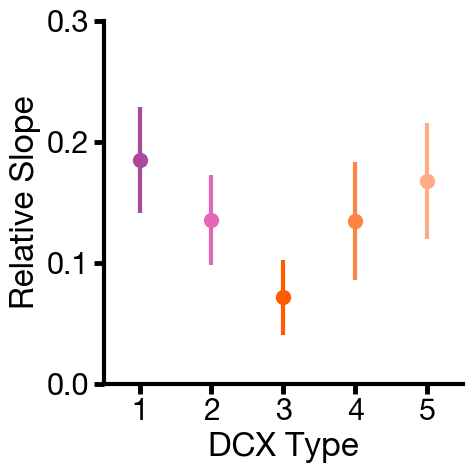

In [190]:
fig, ax = plt.subplots(1,1,figsize=(5.25,5.25))

count = 1
for dcxtype in ResultFit[Type].unique()[1:-1]:

    
    fitparams = lin_fit_results[lin_fit_results['DCX Type']==dcxtype]
    p = fitparams['Relative Slope'].values
    psd = fitparams['Relative Slope SD'].values
    b = fitparams['Intercept'].values
    bsd = fitparams['Intercept SD'].values


    ax.errorbar([count], p, yerr=psd, color = palette_all[count],marker = 'o',markersize = 10)
    #sns.catplot(data= )

    count += 1

ax.set_ylabel('Relative Slope')
ax.set_xlabel('DCX Type')

ax.set_xlim(0.5,5.5)
ax.set_xticks(np.arange(1, 5.1,1))
ax.set_ylim(0,0.3)
ax.set_yticks(np.arange(0, 0.31,0.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
plt.tight_layout()
plt.savefig(newmydir/('relative_slope_'+date+'.pdf'))



## GROWTH ##

In [40]:

G_lin_fit_results = pd.DataFrame(columns=[] , index=[])

for dcxtype in ResultFit[Type].unique()[1:-1]:#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    p , SElin, R, chi = lin_fit(dcxtype,0)

    results0 = {'DCX Type': [dcxtype], 'Slope': [p[0]], 'Slope SD': [SElin[0]], 'Intercept': [p[1]], 'Intercept SD': [SElin[1]], r'$R^2$': [R], 'chi^2': [chi]}

    G_lin_fit_results = pd.concat([G_lin_fit_results, pd.DataFrame(results0)], sort=False)



In [41]:
x,y,yerr = pickdata('WT', 0)
x0,y0,yerr0 = pickdata('None', 0)

X = [*x0,*x]
Y = [*y0,*y]
Yerr = [*yerr0,*yerr]

p, cov = np.polyfit(X,Y, 1, cov=True)
var = np.diagonal(cov) #Refer [3]
SElin = np.sqrt(var) #Refer [4]

fitY = np.multiply(X,p[0])+p[1]

R = R2S(Y,fitY)

chi = reduced_chi_squared(Y,fitY,Yerr,len(Y)-2)

results0 = {'DCX Type': ['WT'], 'Slope': [p[0]], 'Slope SD': [SElin[0]], 'Intercept': [p[1]], 'Intercept SD': [SElin[1]], r'$R^2$': [R], 'chi^2': [chi]}
G_lin_fit_results = pd.concat([G_lin_fit_results, pd.DataFrame(results0)], sort=False)

G_lin_fit_results['Relative Slope'] = G_lin_fit_results['Slope']/p[0]
G_lin_fit_results['Relative Slope SD'] = np.abs( G_lin_fit_results['Slope']/p[0]) * np.sqrt(np.square(SElin[0]/p[0])+np.square(G_lin_fit_results['Slope SD']/G_lin_fit_results['Slope']))

G_lin_fit_results

,DCX Type,Slope,Slope SD,Intercept,Intercept SD,$R^2$,chi^2,Relative Slope,Relative Slope SD
0,Y64N,0.000780,0.000275,0.410924,0.030701,0.668833,126.808144,4.977703,6.128810
0,R76S,0.000357,0.000140,0.434344,0.015619,0.619904,21.332185,2.275711,2.829109
0,R178L,0.000503,0.000456,0.455904,0.050991,0.233223,223.963996,3.208371,4.774044
0,P191R,-0.000044,0.000196,0.408700,0.021954,0.012251,120.947647,-0.278934,1.294849
0,G223E,0.000539,0.000474,0.451517,0.052960,0.244324,270.930427,3.435561,5.055566
0,WT,0.000157,0.000185,0.400706,0.020684,0.152235,139.503515,1.000000,1.668651


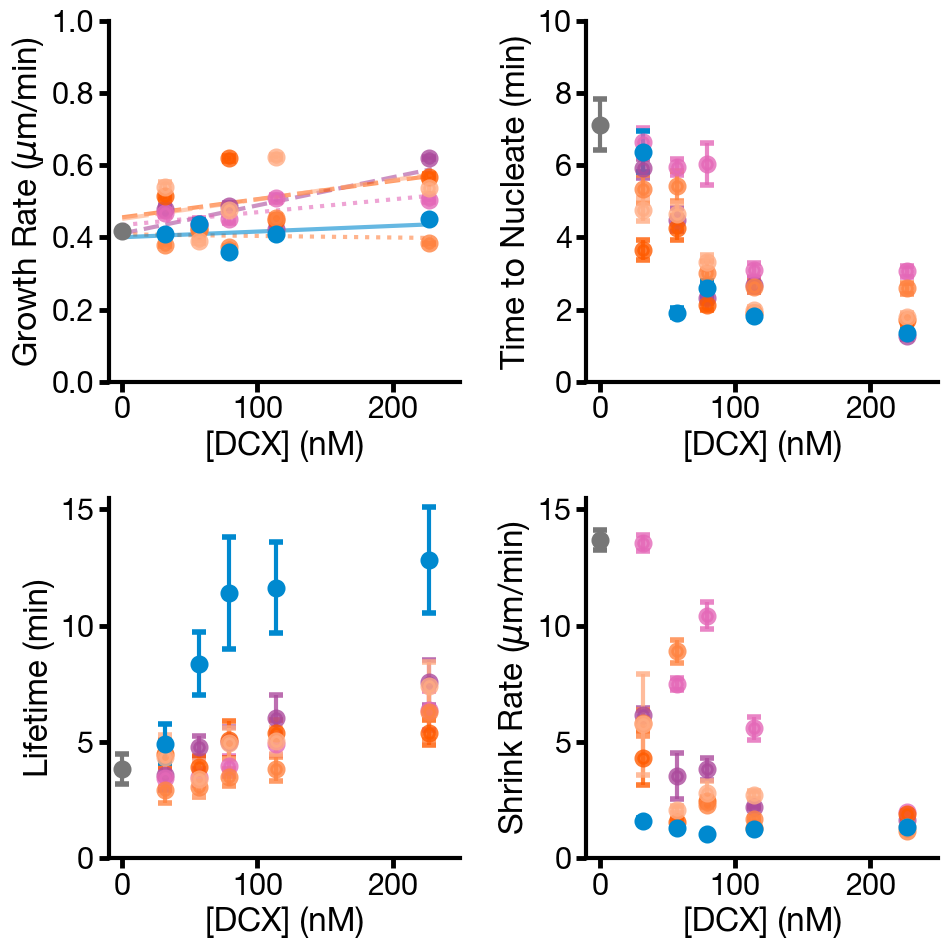

In [85]:
scattersize = 9
cap = 5

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shrinkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

fig, ax = plt.subplots(2,2,figsize=(10,10))

linx = np.arange(0, 230, 1)

# ax[0][0].plot(linx, linx*mG+bG ,color = cyan, lw=3,ls= '-',alpha = 0.5,label='_nolegend_')


linetype = ['','--', ':','--', ':', '-.','-']


count = 0

palette = palette_all
#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
#palette = [grey,cyan]

for dcxtype in ResultFit[Type].unique():#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Moment']=='Mean')& (ResultFit[tubulin]==6)]

    
    
    c=0
    for i in np.arange(len(ax)):
        for j in np.arange(len(ax)):
    
            parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[c]]

            x = parameterMeanDF[DCXconc].values
            y = parameterMeanDF['Fit'].values
            yerr = parameterMeanDF['SE'].values
            
            if dcxtype == 'None' or  dcxtype == 'WT':

                ax[i][j].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
            else:
                ax[i][j].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)

            c += 1

    count += 1


count = 1
for dcxtype in ResultFit[Type].unique()[1:]:
    
    fitparams = G_lin_fit_results[G_lin_fit_results['DCX Type']==dcxtype]
    p = fitparams['Slope'].values
    b = fitparams['Intercept'].values
    ax[0][0].plot(linx, linx*p+b ,color = palette_all[count], lw=3,ls= linetype[count],alpha = 0.6,label='_nolegend_')

    count += 1

ax[0][0].set_ylim(0,1)
ax[1][0].set_ylim(0,15.5)
ax[0][1].set_ylim(0,10)
ax[1][1].set_ylim(0,15.5)


# linx = np.arange(30, 230, 1)
# ax[1][1].plot(linx, linx*mS+bS,color = cyan, lw=3,ls= '-',alpha = 0.5)

count = 0
for i in np.arange(len(ax)):
    for j in np.arange(len(ax)):
    
          
        ax[i][j].set_xlim(-10,250)
        ax[i][j].set_xlabel(DCXconc)
        ax[i][j].set_xticks(np.arange(0, 251, 100))
        ax[i][j].set_ylabel(ylables[count])
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['left'].set_lw(3)
        ax[i][j].spines['bottom'].set_lw(3)
        ax[i][j].tick_params(axis='both', width = 3.5, length = 7)
        #ax[i][1].legend((Type_order),loc='upper right',title='DCX Type')
        #ax[i][j].set_title(titles[count])
        ax[i][j].margins(2)
        count += 1

#ax[0][0].legend((Type_order),loc='upper right',title='DCX Type')
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
plt.tight_layout()

plt.savefig(newmydir/('growth_linfit__all-mutants'+date+'.pdf'))

In [86]:
newmydir

WindowsPath('C:/Users/sofia/OneDrive - McGill University/EJCB2023/Sofia_EJCB_Figs/Data/2023-08-08_fitdata-final/Plots_2024-01-29')

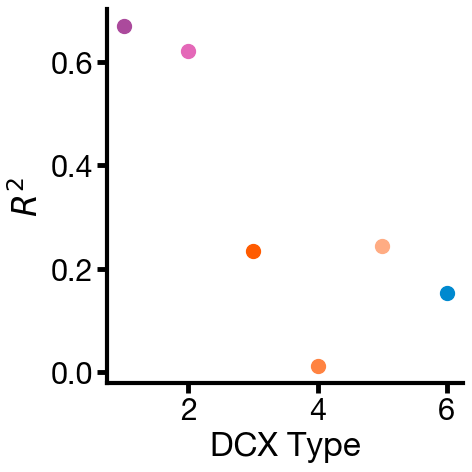

In [70]:
fig, ax = plt.subplots(1,1,figsize=(5.25,5.25))

count = 1
for dcxtype in ResultFit[Type].unique()[1:]:

    
    fitparams = G_lin_fit_results[G_lin_fit_results['DCX Type']==dcxtype]
    p = fitparams[r'$R^2$'].values
    psd = fitparams['Relative Slope SD'].values
    b = fitparams['Intercept'].values
    bsd = fitparams['Intercept SD'].values


    ax.errorbar([count], p, color = palette_all[count],marker = 'o',markersize = 10)
    #sns.catplot(data= )

    count += 1

ax.set_ylabel(r'$R^2$')
ax.set_xlabel('DCX Type')

# ax.set_xlim(0.5,5.5)
# ax.set_xticks(np.arange(1, 5.1,1))
# ax.set_ylim(0,0.3)
# ax.set_yticks(np.arange(0, 0.31,0.1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
plt.tight_layout()
#plt.savefig(newmydir/('relative_slope_'+date+'.pdf'))



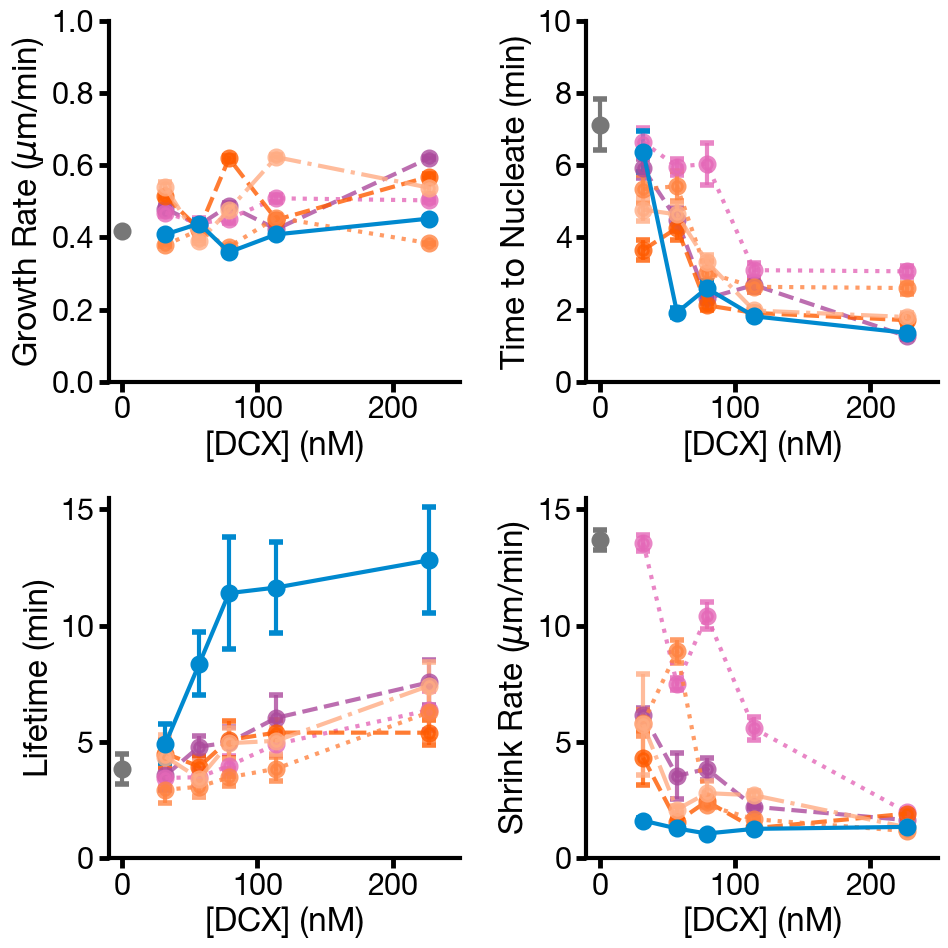

In [88]:
scattersize = 9
cap = 5

parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shrinkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

fig, ax = plt.subplots(2,2,figsize=(10,10))

linx = np.arange(0, 230, 1)

# ax[0][0].plot(linx, linx*mG+bG ,color = cyan, lw=3,ls= '-',alpha = 0.5,label='_nolegend_')


linetype = ['','--', ':','--', ':', '-.','-']


count = 0

palette = palette_all
#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
#palette = [grey,cyan]

for dcxtype in ResultFit[Type].unique():#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Moment']=='Mean')& (ResultFit[tubulin]==6)]

    
    
    c=0
    for i in np.arange(len(ax)):
        for j in np.arange(len(ax)):
    
            parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[c]]

            x = parameterMeanDF[DCXconc].values
            y = parameterMeanDF['Fit'].values
            yerr = parameterMeanDF['SE'].values
            
            if dcxtype == 'None' or  dcxtype == 'WT':

                ax[i][j].errorbar(x , y , yerr= yerr , fmt=linetype[count],marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
            else:
                ax[i][j].errorbar(x , y , yerr= yerr , fmt=linetype[count],marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)

            c += 1

    count += 1


# count = 1
# for dcxtype in ResultFit[Type].unique()[1:]:
    
#     fitparams = G_lin_fit_results[G_lin_fit_results['DCX Type']==dcxtype]
#     p = fitparams['Slope'].values
#     b = fitparams['Intercept'].values
#     ax[0][0].plot(linx, linx*p+b ,color = palette_all[count], lw=3,ls= linetype[count],alpha = 0.6,label='_nolegend_')

#     count += 1

ax[0][0].set_ylim(0,1)
ax[1][0].set_ylim(0,15.5)
ax[0][1].set_ylim(0,10)
ax[1][1].set_ylim(0,15.5)


# linx = np.arange(30, 230, 1)
# ax[1][1].plot(linx, linx*mS+bS,color = cyan, lw=3,ls= '-',alpha = 0.5)

count = 0
for i in np.arange(len(ax)):
    for j in np.arange(len(ax)):
    
          
        ax[i][j].set_xlim(-10,250)
        ax[i][j].set_xlabel(DCXconc)
        ax[i][j].set_xticks(np.arange(0, 251, 100))
        ax[i][j].set_ylabel(ylables[count])
        ax[i][j].spines['right'].set_visible(False)
        ax[i][j].spines['top'].set_visible(False)
        ax[i][j].spines['left'].set_lw(3)
        ax[i][j].spines['bottom'].set_lw(3)
        ax[i][j].tick_params(axis='both', width = 3.5, length = 7)
        #ax[i][1].legend((Type_order),loc='upper right',title='DCX Type')
        #ax[i][j].set_title(titles[count])
        ax[i][j].margins(2)
        count += 1

#ax[0][0].legend((Type_order),loc='upper right',title='DCX Type')
sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
plt.tight_layout()

plt.savefig(newmydir/('dyn_all-mutants'+date+'.pdf'))

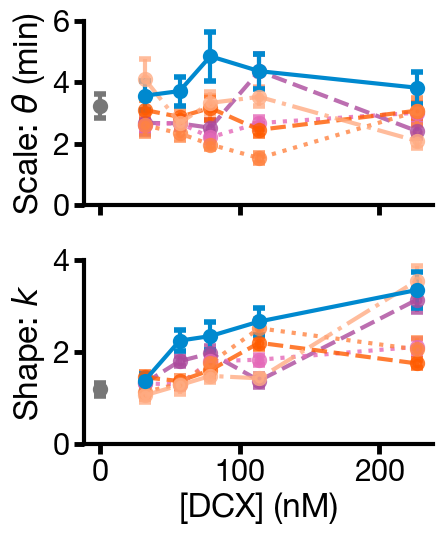

In [24]:
parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shronkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

scattersize = 7
cap = 4

fig, ax = plt.subplots(2,1,figsize=(4.5,5.5),sharex=True)
fig.subplots_adjust(hspace=0.3)
#     plt.suptitle('Fitted pooled data', fontsize=30)
#selectcoeff = ResultFit.dropna(subset=['Coefficient'])

count = 0

#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan]
#[grey,cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
palette = palette_all

for dcxtype in ResultFit[Type].unique():#data[Type].unique(): #['None','R76S','P191R','WT']: #
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Parameter']==Lifetime)
                           & (ResultFit[tubulin]==6)].dropna(subset=['Coefficient'])

    x = dcxtype_DF[(dcxtype_DF['Coefficient']==0)][DCXconc].values
    
    y = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['Fit'].values
    yerr = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['SE'].values

    if dcxtype == 'None' or  dcxtype == 'WT':

        ax[1].errorbar(x , y , yerr= yerr , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
    else:
        ax[1].errorbar(x , y , yerr= yerr , fmt=linetype[count],marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)
    
    y = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['Fit'].values
    yerr = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['SE'].values

    if dcxtype == 'None' or  dcxtype == 'WT':

        ax[0].errorbar(x , y , yerr= yerr , fmt=linetype[count],marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
    else:
        ax[0].errorbar(x , y , yerr= yerr , fmt=linetype[count],marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)
    
    count += 1

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_lw(3)
    ax[i].spines['bottom'].set_lw(3)
    ax[i].tick_params(axis='both', width = 3.5, length = 7)
    
    ax[i].set_xticks(np.arange(0, 251, 100))
    

ax[1].set_ylim(0,4)    
ax[1].set_yticks(np.arange(0, 4.1, 2))

ax[0].set_ylim(0,6)    
ax[0].set_yticks(np.arange(0, 6.1, 2))


ax[1].set_xlabel( DCXconc)
ax[1].set_ylabel( 'Step: ' r'$k$')

ax[0].set_ylabel( 'Scale: ' r'$\theta$'' (min)')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
#plt.tight_layout()
#ax[0].legend((Type_order),loc='upper left',title='DCX Type')
#fig.suptitle('[Tubulin] ' r'$= 6 \mu M$')

#plt.savefig(path.parents[0]/('joint_graphsFit_'+jointdate+'.png'))
#plt.savefig(newmydir/('joint_graphsFit_lifetimeparms_all-mutants.pdf'),bbox_inches='tight')

In [31]:
dcxtype = 'WT'

dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Parameter']==Lifetime)
                           & (ResultFit[tubulin]==6)].dropna(subset=['Coefficient'])

x = dcxtype_DF[(dcxtype_DF['Coefficient']==0)][DCXconc].values
    
yK = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['Fit'].values
yerrK = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['SE'].values


yth = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['Fit'].values
yerrth = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['SE'].values


In [36]:
dcxtype = 'None'

dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Parameter']==Lifetime)
                           & (ResultFit[tubulin]==6)].dropna(subset=['Coefficient'])

yK0 = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['Fit'].values
yth0 = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['Fit'].values

In [38]:
X = [*x0,*x]
YK = [*yK0,*yK]
YerrK = [*yerr0,*yerr]

logx = np.log(X[1:-1])
normyK =( YK[1:-1]-YK[0])/(YK[-1]-YK[0])
logyK = np.log(normyK/(1-normyK))

p, cov = np.polyfit(logx, logyK, 1, cov=True)
var = np.diagonal(cov) #Refer [3]
SElin = np.sqrt(var) #Refer [4]

mL,bL = p


p, SElin

(array([  2.39741239, -10.32358702]), array([0.54745929, 2.28824294]))

In [53]:
K_A(p)

(74.15350515461871, 101.61812839898073)

In [42]:
R2S(logyK,logx*mL+bL)

0.9055581467315158

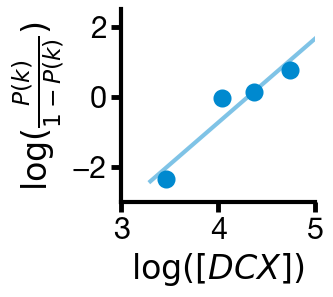

In [48]:
scattersize = 9
cap = 5
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
ax.errorbar(logx , logyK , yerr= 0 , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,color=cyan, alpha = 1, ls='')

x0 = np.arange(3.3, 5.4, 0.05)
ax.plot(x0, x0*p[0]+p[1],color = cyan, lw=3,ls= '-',alpha = 0.5)

ax.set_ylim(-3,2.5)
ax.set_xlim(3,5)
ax.set_xlabel(r'$\log([DCX])$')
#ax.set_xticks(np.arange(0, 22.1, 2))
#ax.set_yticks(np.arange(0, 150.1, 25))
ax.set_ylabel(r'$\log(\frac{P(k)}{1-P(k)})$') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_lw(3)
ax.spines['bottom'].set_lw(3)
ax.tick_params(axis='both', width = 3.5, length = 7)

#ax.legend((r'$n=2.46 \pm 0.29$' '\n' r'$R^2 > 0.959$',),loc='lower right',title='Hill Equation')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})

#plt.savefig(newmydir/('logexpHillfit_Rescues_'+date+'.svg'))

In [50]:
def hillEQ(x, n, kd, Y):
    return  (Y[-1]- Y[0]) * np.power(x, n)/(kd + np.power(x, n)) + Y[0]

In [71]:
def hillEQfit(x, n, kd, sat):
    return  sat * np.power(x, n)/(kd + np.power(x, n)) + YK[0]

In [72]:
coeffH, var_matrixH = sp.optimize.curve_fit(hillEQfit,X,YK)

varianceH = np.diagonal(var_matrixH) #Refer [3]
SEH = np.sqrt(varianceH)

coeffH,SEH

C:\Users\sofia\AppData\Local\Temp\ipykernel_24720\1414062771.py:2: RuntimeWarning: divide by zero encountered in power
  return  sat * np.power(x, n)/(kd + np.power(x, n)) + YK[0]
C:\Users\sofia\AppData\Local\Temp\ipykernel_24720\1414062771.py:2: RuntimeWarning: invalid value encountered in divide
  return  sat * np.power(x, n)/(kd + np.power(x, n)) + YK[0]


(array([1.84826998e+00, 3.38028435e+03, 2.43425017e+00]),
 array([6.96544048e-01, 8.93502263e+03, 5.08204211e-01]))

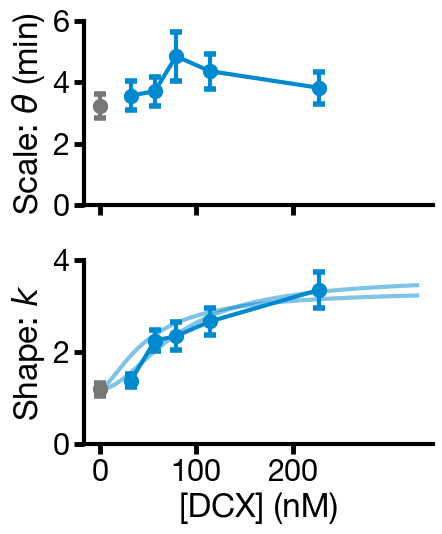

In [81]:
parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shronkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

scattersize = 7
cap = 4

fig, ax = plt.subplots(2,1,figsize=(4.5,5.5),sharex=True)
fig.subplots_adjust(hspace=0.3)
#     plt.suptitle('Fitted pooled data', fontsize=30)
#selectcoeff = ResultFit.dropna(subset=['Coefficient'])

count = 0

#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan]
#[grey,cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
palette = [grey,cyan]#palette_all

linx = np.arange(0, 330, 1)
ax[1].plot(linx, hillEQ(linx,1.5, 350, YK),color = cyan, lw=3,ls= '-',alpha = 0.5,label='_nolegend_')
ax[1].plot(linx, hillEQfit(linx,coeffH[0], coeffH[1], coeffH[2]),color = cyan, lw=3,ls= '-',alpha = 0.5,label='_nolegend_')

for dcxtype in ['None','WT']:#ResultFit[Type].unique(): #['None','R76S','P191R','WT']: #
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Parameter']==Lifetime)
                           & (ResultFit[tubulin]==6)].dropna(subset=['Coefficient'])

    x = dcxtype_DF[(dcxtype_DF['Coefficient']==0)][DCXconc].values
    
    y = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['Fit'].values
    yerr = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['SE'].values

    if dcxtype == 'None' or  dcxtype == 'WT':

        ax[1].errorbar(x , y , yerr= yerr , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
    else:
        ax[1].errorbar(x , y , yerr= yerr , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)
    
    y = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['Fit'].values
    yerr = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['SE'].values

    if dcxtype == 'None' or  dcxtype == 'WT':

        ax[0].errorbar(x , y , yerr= yerr , fmt='',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
    else:
        ax[0].errorbar(x , y , yerr= yerr , fmt=linetype[count],marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)
    
    count += 1

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_lw(3)
    ax[i].spines['bottom'].set_lw(3)
    ax[i].tick_params(axis='both', width = 3.5, length = 7)
    
    ax[i].set_xticks(np.arange(0, 251, 100))
    

ax[1].set_ylim(0,4)    
ax[1].set_yticks(np.arange(0, 4.1, 2))

ax[0].set_ylim(0,6)    
ax[0].set_yticks(np.arange(0, 6.1, 2))


ax[1].set_xlabel( DCXconc)
ax[1].set_ylabel( 'Step: ' r'$k$')

ax[0].set_ylabel( 'Scale: ' r'$\theta$'' (min)')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
#plt.tight_layout()
#ax[0].legend((Type_order),loc='upper left',title='DCX Type')
#fig.suptitle('[Tubulin] ' r'$= 6 \mu M$')

#plt.savefig(path.parents[0]/('joint_graphsFit_'+jointdate+'.png'))
#plt.savefig(newmydir/('joint_graphsFit_lifetimeparms_all-mutants.pdf'),bbox_inches='tight')

In [42]:
def pickdata2(dcxtype, parameterNo, coeffNo):
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Coefficient']==coeffNo)& (ResultFit[tubulin]==6)]

    parameterMeanDF = dcxtype_DF[dcxtype_DF['Parameter']==parameters[parameterNo]]

    x = parameterMeanDF[DCXconc].values
    y = parameterMeanDF['Fit'].values
    yerr = parameterMeanDF['SE'].values
    
    return x,y,yerr

In [43]:
def lin_fit2(dcxtype,paramNo,coeffNo):
    x,y,yerr = pickdata2(dcxtype,paramNo,coeffNo)
    x0,y0,yerr0 = pickdata2('None',paramNo,coeffNo)
    
    X = [*x0,*x]
    Y = [*y0,*y]
    Yerr = [*yerr0,*yerr]
    
    p, cov = np.polyfit(X,Y, 1, cov=True)
    var = np.diagonal(cov) #Refer [3]
    SElin = np.sqrt(var) #Refer [4]

    fitY = np.multiply(X,p[0])+p[1]
    
    R = R2S(Y,fitY)

    chi = reduced_chi_squared(Y,fitY,Yerr,len(Y)-2)
    
    return p, SElin, R, chi

In [78]:
step_lin_fit_results = pd.DataFrame(columns=[] , index=[])

for dcxtype in ResultFit[Type].unique()[1:]:#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    p , SElin, R, chi = lin_fit2(dcxtype,2,0)

    results0 = {'DCX Type': [dcxtype], 'Slope': [p[0]], 'Slope SD': [SElin[0]], 'Intercept': [p[1]], 'Intercept SD': [SElin[1]], 'R^2': [R], 'chi^2': [chi]}
    

    step_lin_fit_results = pd.concat([step_lin_fit_results, pd.DataFrame(results0)], sort=False)
    
step_lin_fit_results['Relative Slope'] = step_lin_fit_results['Slope']/p[0]
step_lin_fit_results['Relative Slope SE'] = step_lin_fit_results['Slope']/p[0] * np.sqrt(np.square(SElin[0]/p[0])+np.square(step_lin_fit_results['Slope SD']/step_lin_fit_results['Slope']))    

step_lin_fit_results

,DCX Type,Slope,Slope SD,Intercept,Intercept SD,R^2,chi^2,Relative Slope,Relative Slope SE
0,Y64N,0.007970,0.002122,1.129725,0.237260,0.779145,7.500168,0.835650,0.266509
0,R76S,0.004297,0.000931,1.231938,0.104063,0.842067,2.441604,0.450586,0.125629
0,R178L,0.002774,0.001737,1.363639,0.194247,0.389384,5.850043,0.290873,0.189154
0,P191R,0.004973,0.002404,1.243753,0.268898,0.516741,5.024046,0.521410,0.268235
0,G223E,0.010851,0.002247,0.749067,0.251324,0.853550,10.957780,1.137753,0.308964
0,WT,0.009537,0.001675,1.391053,0.187327,0.890160,2.466939,1.000000,0.248388


In [61]:
scale_lin_fit_results = pd.DataFrame(columns=[] , index=[])

for dcxtype in ResultFit[Type].unique()[1:]:#ResultFit[Type].unique(): #data[Type].unique(): #['None','R76S','P191R','WT']
    
    p , SElin, R, chi = lin_fit2(dcxtype,2,1)

    results0 = {'DCX Type': [dcxtype], 'Slope': [p[0]], 'Slope SD': [SElin[0]], 'Intercept': [p[1]], 'Intercept SD': [SElin[1]], 'R^2': [R], 'chi^2': [chi]}

    scale_lin_fit_results = pd.concat([scale_lin_fit_results, pd.DataFrame(results0)], sort=False)
scale_lin_fit_results

,DCX Type,Slope,Slope SD,Intercept,Intercept SD,R^2,chi^2
0,Y64N,-0.001078,0.004578,3.064072,0.511935,0.013674,4.185780
0,R76S,0.000201,0.002204,2.714056,0.246495,0.002081,2.789162
0,R178L,-0.000853,0.001739,3.050279,0.194521,0.056760,2.144466
0,P191R,-0.000300,0.004029,2.475083,0.450568,0.001386,12.400448
0,G223E,-0.005809,0.003291,3.647996,0.368057,0.437827,2.153334
0,WT,0.002415,0.003466,3.714941,0.387610,0.108250,1.083895


In [53]:
ResultFit[Type].unique()

array(['None', 'Y64N', 'R76S', 'R178L', 'P191R', 'G223E', 'WT'],
      dtype=object)

In [54]:
palette_all

['#777777', '#ab4a9c', '#e468b8', '#ff5b00', '#ff8341', '#ffac83', '#0089CF']

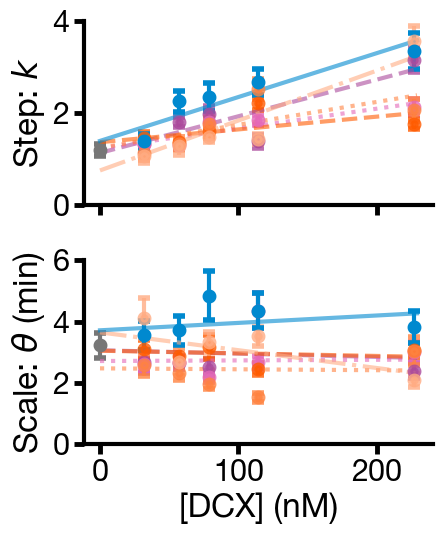

In [72]:
parameters = [GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate]
titles = ('Growth','Nucleation','Lifetime','Shronkage Rate')
ylables = (GrowthRate,TimeToNucleate,Lifetime,ShrinkageRate)

scattersize = 6
cap = 4
linetype = ['','--', ':','--', ':', '-.','-']
linx = np.arange(0, 230, 1)

fig, ax = plt.subplots(2,1,figsize=(4.5,5.5),sharex=True)
fig.subplots_adjust(hspace=0.3)
#     plt.suptitle('Fitted pooled data', fontsize=30)
#selectcoeff = ResultFit.dropna(subset=['Coefficient'])

count = 0

#palette = [grey,list(map(Color.get_hex,DC1color))[1],list(map(Color.get_hex,DC2color))[1],cyan]
#[grey,cyan] #+ list(map(Color.get_hex,DC1color)) + list(map(Color.get_hex,DC2color)) + [green,cyan]
palette = palette_all

for dcxtype in ResultFit[Type].unique():#data[Type].unique(): #['None','R76S','P191R','WT']: #
    
    dcxtype_DF = ResultFit[(ResultFit[Type]==dcxtype) & (ResultFit['Parameter']==Lifetime)
                           & (ResultFit[tubulin]==6)].dropna(subset=['Coefficient'])

    x = dcxtype_DF[(dcxtype_DF['Coefficient']==0)][DCXconc].values
    
    y = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['Fit'].values
    yerr = dcxtype_DF[(dcxtype_DF['Coefficient']==0)]['SE'].values

    if dcxtype == 'None' or  dcxtype == 'WT':

        ax[0].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
    else:
        ax[0].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)
    
    y = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['Fit'].values
    yerr = dcxtype_DF[(dcxtype_DF['Coefficient']==1)]['SE'].values

    if dcxtype == 'None' or  dcxtype == 'WT':

        ax[1].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 1)
            
    else:
        ax[1].errorbar(x , y , yerr= yerr , fmt=' ',marker='o', markersize=scattersize,capsize = cap,
                              markeredgewidth=4,elinewidth=3,color=palette[count], alpha = 0.80)
    
    count += 1

cnt = 1
for dcxtype in ResultFit[Type].unique()[1:]:
    
    fitparams = step_lin_fit_results[step_lin_fit_results['DCX Type']==dcxtype]
    p = fitparams['Slope'].values
    b = fitparams['Intercept'].values
    ax[0].plot(linx, linx*p+b ,color = palette_all[cnt], lw=3,ls= linetype[cnt],alpha = 0.6,label='_nolegend_')
    
    fitparams = scale_lin_fit_results[scale_lin_fit_results['DCX Type']==dcxtype]
    p = fitparams['Slope'].values
    b = fitparams['Intercept'].values
    ax[1].plot(linx, linx*p+b ,color = palette_all[cnt], lw=3,ls= linetype[cnt],alpha = 0.6,label='_nolegend_')

    cnt += 1
    

for i in [0,1]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_lw(3)
    ax[i].spines['bottom'].set_lw(3)
    ax[i].tick_params(axis='both', width = 3.5, length = 7)
    
    ax[i].set_xticks(np.arange(0, 251, 100))
    

ax[0].set_ylim(0,4)    
ax[0].set_yticks(np.arange(0, 4.1, 2))

ax[1].set_ylim(0,6)    
ax[1].set_yticks(np.arange(0, 6.1, 2))


ax[1].set_xlabel( DCXconc)
ax[0].set_ylabel( 'Step: ' r'$k$')

ax[1].set_ylabel( 'Scale: ' r'$\theta$'' (min)')

sns.set_context("poster", font_scale=1, rc={"lines.linewidth":3.0})
#plt.tight_layout()
#ax[0].legend((Type_order),loc='upper left',title='DCX Type')
#fig.suptitle('[Tubulin] ' r'$= 6 \mu M$')

#plt.savefig(path.parents[0]/('joint_graphsFit_'+jointdate+'.png'))
plt.savefig(newmydir/('joint_graphsFit_lifetimeparms_all-mutants.pdf'),bbox_inches='tight')